In [1]:
import numpy as np
import xarray as xr
import datetime as date
import pandas as pd
from datetime import datetime
from datetime import timedelta
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import erddapy
from erddapy import ERDDAP
from cmocean import cm as cmo
myFmtlong = mdates.DateFormatter('%m/%d\n%H:%M')
myFmt = mdates.DateFormatter('%m/%d')

## Set plotting parameters
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

# increase text sizes because the figure is so big
fac =1.5
plt.rc('font', size=SMALL_SIZE * fac)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE * fac)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE * fac)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE * fac)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE * fac)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE * fac)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE * fac *0.8)  # fontsize of the figure title

In [2]:
def stick_plot(time, u, v,setscale, **kw):
    '''Time is supposed to be in datenum'''
    

    width = kw.pop('width', 0.002)
    headwidth = kw.pop('headwidth', 0)
    headlength = kw.pop('headlength', 0)
    headaxislength = kw.pop('headaxislength', 0)
    angles = kw.pop('angles', 'uv')
    ax = kw.pop('ax', None)
    
    if angles != 'uv':
        raise AssertionError("Stickplot angles must be 'uv' so that"
                             "if *U*==*V* the angle of the arrow on"
                             "the plot is 45 degrees CCW from the *x*-axis.")

    time, u, v = map(np.asanyarray, (time, u, v))
    if not ax:
        fig = plt.figure(figsize=(27,10))
    
    q = plt.quiver(time, [[0]*len(time)], u, v,
                  angles='uv', width=width, headwidth=headwidth,
                  headlength=headlength, headaxislength=headaxislength,scale=setscale,
                  **kw)

    plt.gca().axes.get_yaxis().set_visible(False)
    plt.gca().xaxis_date()
    return q

Start by pulling in the buoy data using some code from Mike Smith

In [3]:
def get_ndbc(bbox=None, time_start=None, time_end=None, buoy=None):
    '''
    Credit: Mike Smith
    Used to pull observational data from NDBC buoys off of ERDDAP
    '''
    bbox = bbox or [-100, -45, 5, 46]
    time_end = time_end or dt.date.today()
    time_start = time_start or (time_end - dt.timedelta(days=1))
    buoy = buoy or False
    time_formatter = '%Y-%m-%dT%H:%M:%SZ'

    e = ERDDAP(
        server='CSWC',
        protocol='tabledap',
        response='csv'
    )

    e.dataset_id = 'cwwcNDBCMet'
    e.constraints = {
        'time>=': time_start.strftime(time_formatter),
        'time<=': time_end.strftime(time_formatter),
    }

    if bbox:
        e.constraints['longitude>='] = bbox[0]
        e.constraints['longitude<='] = bbox[1]
        e.constraints['latitude>='] = bbox[2]
        e.constraints['latitude<='] = bbox[3]

    if buoy:
        e.constraints['station='] = buoy

    e.variables = [
        "latitude",
        "longitude",
        "wd",
        "wspd",
        "gst",
        "wvht",
        "dpd",
        "apd",
        "mwd",
        "bar",
        "atmp",
        "wtmp",
        "dewp",
        # "vis",
        # "ptdy",
        # "tide",
        "wspu",
        "wspv",
        "time",
    ]



    try:
        df = e.to_pandas(
            parse_dates=['time (UTC)'],
            skiprows=(1,)  # units information can be dropped.
        ).dropna()
    except HTTPError:
        df = pd.DataFrame()

    return df

In [4]:
# Played with the date range until it looked like we fully captured before during and after the storm
start_date = datetime(2021, 8, 25)
end_date = datetime(2021, 9, 6)
buoydf = get_ndbc(bbox=None,time_start=start_date, time_end=end_date, buoy='42040')

In [5]:
buoydf

,latitude (degrees_north),longitude (degrees_east),wd (degrees_true),wspd (m s-1),gst (m s-1),wvht (m),dpd (s),apd (s),mwd (degrees_true),bar (hPa),atmp (degree_C),wtmp (degree_C),dewp (degree_C),wspu (m s-1),wspv (m s-1),time (UTC)
3,29.212,-88.207,197.0,1.4,2.0,0.31,7.69,4.20,148.0,1014.7,30.0,30.2,25.4,0.4,1.3,2021-08-25 00:40:00+00:00
9,29.212,-88.207,197.0,1.2,2.9,0.32,7.14,4.39,147.0,1015.0,30.0,30.1,25.4,0.4,1.1,2021-08-25 01:40:00+00:00
15,29.212,-88.207,202.0,1.5,1.9,0.29,7.69,4.34,144.0,1015.2,30.0,30.2,25.4,0.6,1.4,2021-08-25 02:40:00+00:00
21,29.212,-88.207,233.0,2.6,3.3,0.28,8.33,4.54,128.0,1015.1,29.9,30.2,25.0,2.1,1.6,2021-08-25 03:40:00+00:00
27,29.212,-88.207,239.0,1.7,2.2,0.27,7.69,4.40,145.0,1015.6,29.9,30.4,24.8,1.5,0.9,2021-08-25 04:40:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1701,29.212,-88.207,70.0,3.0,3.9,0.33,5.00,4.15,105.0,1014.0,28.5,29.4,23.8,-2.8,-1.0,2021-09-05 19:40:00+00:00
1707,29.212,-88.207,75.0,2.3,3.6,0.34,5.00,4.25,99.0,1013.6,28.6,29.4,23.6,-2.2,-0.6,2021-09-05 20:40:00+00:00
1713,29.212,-88.207,59.0,1.4,2.2,0.33,5.26,4.25,103.0,1013.3,28.8,29.7,23.4,-1.2,-0.7,2021-09-05 21:40:00+00:00
1719,29.212,-88.207,108.0,2.3,3.0,0.33,5.00,4.21,104.0,1012.8,28.8,30.2,23.6,-2.2,0.7,2021-09-05 22:40:00+00:00


# Now grab some model/reanalysis data

Jaden keeps the data on boardwalk in /home/jad438/validation_data/hrrrdata/ and he has netcdfs of every day that cover our area of interest. Once I figure out how to efficiently load that data, I will grab two points, one point near the buoy and the other near the glider position. Then I can get timeseries of uv winds at those points and validate against the buoy. There are 1/2 a dozen ndbc stations to choose from in the region to validate the winds against.

In [6]:
def load_hrrr(start_date, end_date, buoy, point_location, height):
    #directory = '/Volumes/home/jad438/validation_data/hrrrdata/'
    directory='/Users/coakley/Github/Ida/data/forcing/hrrr/'
    sites = pd.read_csv(point_location, skipinitialspace=True)
    time_span_D = pd.date_range(start_date, end_date-timedelta(hours=23), freq='D')  #  -timedelta(days=1) was removed from here
    hrrr_ws = []
    hrrr_EWwind = []
    hrrr_NWwind = []
    hrrr_dt = np.empty((0,), dtype='datetime64[m]')
    hrrr_height = []
    for ind, date in enumerate(time_span_D):
        file = 'hrrr_data_' + date.strftime("%Y%m%d") + '.nc'
        try:
            hrrr_ds = xr.open_dataset(directory + file)
            lats = hrrr_ds.gridlat_0.squeeze()
            lons = hrrr_ds.gridlon_0.squeeze()

            site_code = sites[sites['name'] == buoy].index[0]
            a = abs(lats - sites.latitude[site_code]) + abs(lons - sites.longitude[site_code])
            i, j = np.unravel_index(a.argmin(), a.shape)
            
            hrrr_ws = np.append(hrrr_ws, hrrr_ds.wind_speed[:, height, i, j])
            hrrr_dt = np.append(hrrr_dt, hrrr_ds.time)
            hrrr_EWwind = np.append(hrrr_EWwind, hrrr_ds.eastward_wind[:, height, i, j])
            hrrr_NWwind = np.append(hrrr_NWwind, hrrr_ds.northward_wind[:, height, i, j])
            hrrr_height = np.append(hrrr_height, hrrr_ds.lv_HTGL1[height])

        except:
            time_span_H = pd.date_range(date, date + timedelta(hours=23), freq='H')
            hrrr_ws = np.append(hrrr_ws, np.empty(shape=(len(time_span_H))) * np.NAN)
            hrrr_dt = np.append(hrrr_dt, time_span_H)
            hrrr_EWwind = np.append(hrrr_EWwind, np.empty(shape=(len(time_span_H))) * np.NAN)
            hrrr_NWwind = np.append(hrrr_NWwind, np.empty(shape=(len(time_span_H))) * np.NAN)
            hrrr_height = np.append(hrrr_height, np.NAN)

    return hrrr_ws, hrrr_EWwind, hrrr_NWwind, hrrr_dt, hrrr_height

In [7]:
buoy = 'LLNR' # buoy 42040
buoy_location = '/Users/coakley/Github/Ida/data/forcing/buoy_location.csv'
height = 0  
hrrr_windSpeed, hrrr_EWwind, hrrr_NWwind, hrrr_time, hrrr_height = load_hrrr(start_date, end_date, buoy, buoy_location, height)


# Compare the data products to the buoy

/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Winds at Buoy 42040')

/Users/coakley/opt/anaconda3/envs/pangeo/lib/python3.7/site-packages/matplotlib/mathtext.py:2542: SyntaxWarning: Exception creating Regex for oneOf, building MatchFirst
  p.subsuperop    <<= oneOf(["_", "^"])


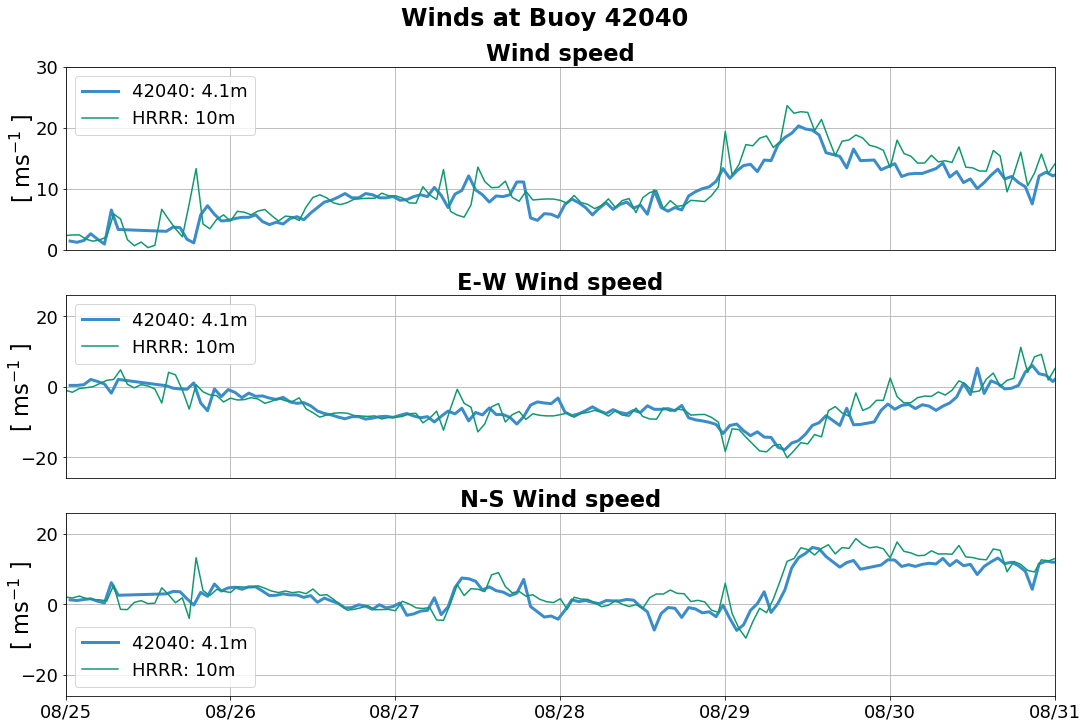

In [8]:
buoy = 'LLNR' # buoy 42040
buoy_location = '/Users/coakley/Github/Ida/data/forcing/buoy_location.csv'
height = 0 
hrrr_windSpeed, hrrr_EWwind, hrrr_NWwind, hrrr_time, hrrr_height = load_hrrr(start_date, end_date, buoy, buoy_location, height)


# Make a big ol' plot to compare the wind products
fig = plt.figure(figsize=(15,10), constrained_layout=True)
xticks=(pd.date_range(start_date, end_date-timedelta(hours=23), freq='1D'))
landfallTime = '2021-08-29T17:00:00'
# xlims = (mdates.datestr2num("2021-8-28 00:00:00"),mdates.datestr2num(landfallTime))
xlims = (mdates.date2num(start_date),mdates.datestr2num("2021-08-31 00:00:00"))
spd_lims = (0,30)
dir_lims = (-26,26)
ICkw = {'ls':':', 'c':'red', 'alpha':0.5, 'lw':3}
ann_kwargs = {'fontsize':20, 'va':'bottom', 'ha':'right'}

# Break it up into sections
gs = fig.add_gridspec(3,1)

# Get colors for lines
N=3
colors = cmo.phase(np.linspace(0.6,0.95,N))

################################################################################
# Plot wind speed
ax = fig.add_subplot(gs[0,:])

ax.plot(buoydf['time (UTC)'],buoydf['wspd (m s-1)'], c=colors[0], label='42040: 4.1m', lw=3)
ax.plot(hrrr_time,hrrr_windSpeed, c=colors[1], label='HRRR: 10m')

ax.legend(loc='upper left')
ax.set_title('Wind speed',fontweight='bold')

# Set the xticks and labels
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.set_xlim(xlims)
ax.set_ylim(spd_lims)
ax.grid(True)
ax.set_ylabel('[ ms$^{-1}$ ]', labelpad=0)
# ax.annotate('(a)',(hrrr_time[-1],dir_lims[0]),xycoords='data', **ann_kwargs) 

################################################################################

################################################################################
# Plot U wind
ax = fig.add_subplot(gs[1,:])

ax.plot(buoydf['time (UTC)'],buoydf['wspu (m s-1)'], c=colors[0], label='42040: 4.1m', lw=3)
ax.plot(hrrr_time,hrrr_EWwind, c=colors[1], label='HRRR: 10m')

ax.legend(loc='upper left')
ax.set_title('E-W Wind speed',fontweight='bold')

# Set the xticks and labels
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.set_xlim(xlims)
ax.set_ylim(dir_lims)
ax.grid(True)
ax.set_ylabel('[ ms$^{-1}$ ]', labelpad=-15)
# ax.annotate('(b)',(hrrr_time[-1],dir_lims[0]),xycoords='data', **ann_kwargs) 

################################################################################

################################################################################
# Plot V wind
ax = fig.add_subplot(gs[2,:])

ax.plot(buoydf['time (UTC)'],buoydf['wspv (m s-1)'], c=colors[0], label='42040: 4.1m', lw=3)
ax.plot(hrrr_time,hrrr_NWwind, c=colors[1], label='HRRR: 10m')

ax.legend()
ax.set_title('N-S Wind speed',fontweight='bold')

# Set the xticks and labels
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.set_xlim(xlims)
ax.set_ylim(dir_lims)
ax.grid(True)
ax.set_ylabel('[ ms$^{-1}$ ]', labelpad=-15)
# ax.annotate('(c)',(hrrr_time[-1],dir_lims[0]),xycoords='data', **ann_kwargs) 
################################################################################
plt.suptitle('Winds at Buoy 42040', fontweight='bold')
# plt.savefig('/Users/coakley/Github/Ida/data/figures/wind_comparisons_at_42040.png',bbox_inches='tight')

# Pull model/reanalysis data from the glider location

Now that we have validated the model data and the buoy location, we can pull from the glider location.

Text(0.5, 0.98, 'Winds at ng645 location')

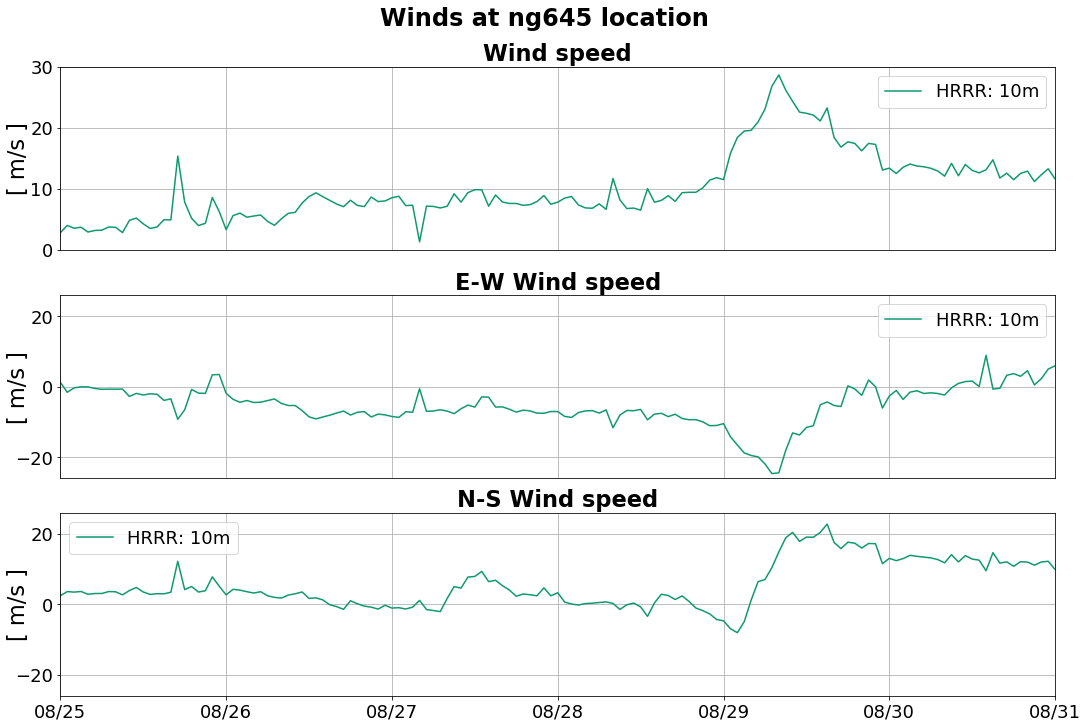

In [9]:
glider = 'ng645'
glider_location = '/Users/coakley/Github/Ida/data/forcing/glider_location.csv'
height = 0 
hrrr_windSpeed, hrrr_EWwind, hrrr_NWwind, hrrr_time, hrrr_height = load_hrrr(start_date, end_date, glider, glider_location, height)

# Make a big ol' plot to look at the winds AT THE GLIDER LOCATION
fig = plt.figure(figsize=(15,10), constrained_layout=True)

# Break it up into sections
gs = fig.add_gridspec(3,1)

# Get colors for lines
N=3
colors = cmo.phase(np.linspace(0.6,0.95,N))

################################################################################
# Plot wind speed
ax = fig.add_subplot(gs[0,:])

ax.plot(hrrr_time,hrrr_windSpeed, c=colors[1], label='HRRR: 10m')

ax.legend()
ax.set_title('Wind speed',fontweight='bold')

# Set the xticks and labels
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.grid(True)
ax.set_xlim(xlims)
ax.set_ylim(spd_lims)
ax.set_ylabel('[ m/s ]', labelpad=0)

################################################################################

################################################################################
# Plot U wind
ax = fig.add_subplot(gs[1,:])

ax.plot(hrrr_time,hrrr_EWwind, c=colors[1], label='HRRR: 10m')

ax.legend()
ax.set_title('E-W Wind speed',fontweight='bold')

# Set the xticks and labels
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.tick_params(labelbottom = False, bottom = False) # Remove bottom tick marks and labels
ax.grid(True)
ax.set_xlim(xlims)
ax.set_ylim(dir_lims)
ax.set_ylabel('[ m/s ]', labelpad=-15)

################################################################################

################################################################################
# Plot V wind
ax = fig.add_subplot(gs[2,:])

ax.plot(hrrr_time,hrrr_NWwind, c=colors[1], label='HRRR: 10m')

ax.legend()
ax.set_title('N-S Wind speed',fontweight='bold')

# Set the xticks and labels
ax.xaxis.set_major_formatter(myFmt)
ax.set_xticks(xticks)
ax.grid(True)
ax.set_xlim(xlims)
ax.set_ylim(dir_lims)
ax.set_ylabel('[ m/s ]', labelpad=-15)
################################################################################
plt.suptitle('Winds at ng645 location', fontweight='bold')
# plt.savefig('/Users/coakley/Github/Ida/data/figures/wind_comparisons_at_ng645.png',bbox_inches='tight')

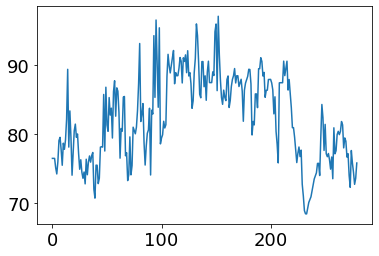

In [10]:
# Check the relative humidity at the buoy
# Need to convert dewpoint T to RH 
# Following a rearranged version of the well known Magnus equation. Some discussion of that equation in Buck 1981
c=243.04
b=17.625
RH = 100*np.exp((c*b * (buoydf['dewp (degree_C)'].values - buoydf['atmp (degree_C)'].values)) / ((c+buoydf['atmp (degree_C)'].values) * (c+buoydf['dewp (degree_C)'].values)) )

plt.plot(RH)

# Grab forcing starting at the time you want to initialize the model from

In [11]:
# Load the data back in with the right time range
glider = 'ng645'
close_prof_id= 1629339767
glider_location = '/Users/coakley/Github/Ida/data/forcing/glider_location.csv'
height = 0 
start_date = datetime(2021, 8, 25, 0) #datetime(2021, 8, 28, 12)
end_date = datetime(2021, 9, 6)
hrrr_windSpeed, hrrr_EWwind, hrrr_NWwind, hrrr_time, hrrr_height = load_hrrr(start_date, end_date, glider, glider_location, height)

# Need to make sure to start at the same time as the glider IC's (2021-08-28 12:16)
hrrr_tind = mdates.date2num(hrrr_time)>=mdates.date2num(start_date)
hrrr_windSpeed = hrrr_windSpeed[hrrr_tind]
hrrr_EWwind = hrrr_EWwind[hrrr_tind]
hrrr_NWwind = hrrr_NWwind[hrrr_tind]
hrrr_time = hrrr_time[hrrr_tind]

## HRRR
#Create dictionary with buoy forcing data
pwp_time = (mdates.date2num(hrrr_time) - mdates.date2num(hrrr_time[0])) # days since start
dummy = np.zeros_like(np.asarray(pwp_time))

# Compute Cd following (Jaimes et al, 2015)
Cd = (4-0.6*hrrr_windSpeed)*10**(-3)
midind = (hrrr_windSpeed >= 5) & (hrrr_windSpeed < 25)
Cd[midind] = (0.7375 + 0.0525*hrrr_windSpeed[midind])*10**(-3)
hiind = (hrrr_windSpeed >= 25)
Cd[hiind] = 2.05*10**(-3)

# Make time variable that starts at 1 and is in decimal days
# Flip signs of heat fluxes to be into ocean is positive
hrrratmo = {'time': {'dims': 'time', 'data': pwp_time}, 
        'sw': {'dims': 'time', 'data': dummy}, 
        'lw': {'dims': 'time', 'data': dummy}, 
        'qlat': {'dims': 'time', 'data': dummy}, 
        'qsens': {'dims': 'time', 'data': dummy}, 
        'tx': {'dims': 'time', 'data': 1.2 * Cd * hrrr_EWwind**2}, 
        'ty': {'dims': 'time', 'data': 1.2 * Cd * hrrr_NWwind**2}, 
        'precip': {'dims': 'time', 'data': dummy}}

hrrratmo_ds = xr.Dataset.from_dict(hrrratmo)
# hrrratmo_ds.to_netcdf('/Users/coakley/Github/Ida/data/forcing/HRRR_Ida_windsOnly_'+str(close_prof_id)+'_08-25-00_initime.nc')